# Analysis of nano-indentation data

Nanoindentation stands as a contemporary method within materials science, offering a meticulous approach to characterizing mechanical properties on the nanoscale. This technique involves the controlled application of force through a sharp tip, typically with a nanometer-scale radius, and the subsequent measurement of material response. By observing the depth of penetration, nanoindentation provides valuable data on hardness, elastic modulus, and other mechanical parameters for materials at the micro- and nanoscale. Its application extends across a spectrum of materials, including metals, ceramics, polymers, and biological tissues. This method is instrumental in gaining insights into the nuanced mechanical behavior of materials, aiding researchers and engineers in the precise tailoring of materials for enhanced performance and durability across diverse applications.


### Credit
Data and images are provided by M. Wollenweber (IMM/RWTH Aachen)

In [1]:
import pandas as pd
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler


# small hack to import the package from the main directory
import sys
sys.path.insert(0, '..')
from tools import plot_dbscan

# for plotting
colour_scheme = 'gist_heat'
marker_size = 12
marker_type = 's'


# Introduction

We will analyse the hardness of the Martensite and Ferrit phase in commercial dual-phase steel (DP800).

The electron microscope image of the relevant part of the material looks like this:

<div style="text-align:center"><img src="./img/Bottom_007.png" style="width: 50%;" class="center"/></div>

We notice immediately that a few artefacts remain on the sample that originate from the metallographic preparation. The following figure highlights two of them, though there are several more (albeit smaller)

<div style="text-align:center"><img src="./img/Bottom_007_annotated.png" style="width: 50%;" class="center"/></div>

We then place an array of nano-indents on the sample and record the response from the measurement device.

Taking images of the area with the nano-indents, we see the following structure.
Note that, depending on the acceleration voltage of the electron beam, we see different features in the material.
The beam with the higher acceleration voltage (2 kV in this example) will penetrate deeper into the material, and, therefore, reveal structures that are below the surface and now visible with a lower acceleration voltage.


| acceleration voltage:  5kV | acceleration voltage: 20 kV |
--- | ---
![](../img/after_indent_001_5kV.png) | ![](../img/after_indent_007_20kV.png)

# Loading data

In the next step, we load the indentation data and look at the quantities of interest



In [2]:
df = pd.read_csv('../data/nanoindent.csv', index_col='index')
df.head(3)

x          y      load      depth      stiffness     modulus  \
index                                                                   
1      0.0  68.294250  0.999767  88.247395  106268.458800  190.653869   
2      0.0  67.579875  0.999758  95.026045  106864.372258  175.243633   
3      0.0  66.913125  0.999791  82.844008  105616.592448  204.800821   

       hardness  
index            
1      3.663756  
2      3.140350  
3      4.181861

In a first step, we look at the hardness.
We expect to see two main contributions from the Martensite and ferrite phase.

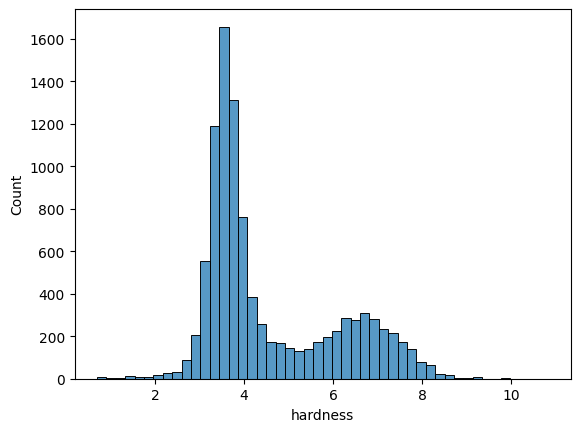

In [3]:
sns.histplot(df['hardness'])
plt.show()

We also look at the elastic modulus:

<Axes: xlabel='modulus', ylabel='Count'>

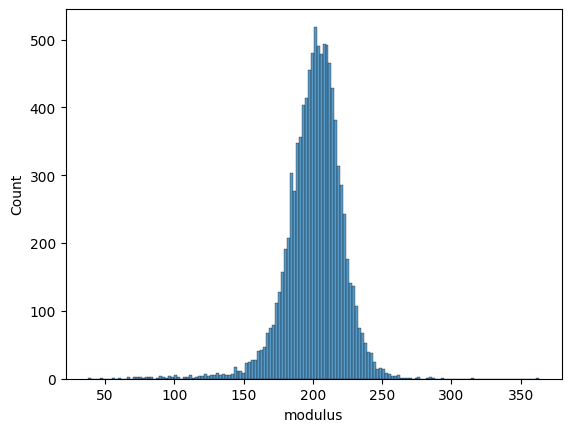

In [4]:
sns.histplot(df['modulus'])

Next we look at the distribution of the measured hardness and elastic modulus across the sample.
To do this, we create a scatterplot of the $x$ and $y$ positions of the measurements and use the value for either hardness or elastic modulus for the choice of colour. Using a colour map from black to red, we can see how the measured values vary across the sample.

We can also see that the two measurements reveal different aspects about our sample.

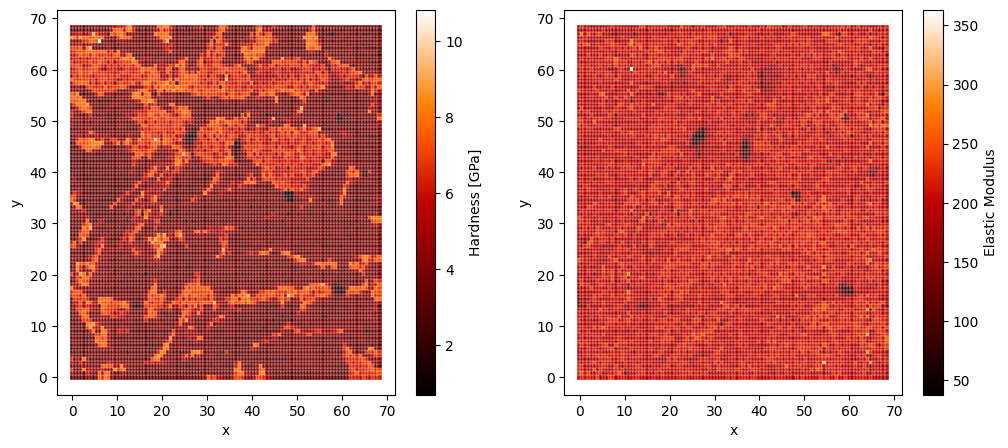

In [5]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))


# left part: hardness
sns.scatterplot(x=df['x'], y=df['y'], hue=df['hardness'],
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type,
                  ax=axs[0])
norm = plt.Normalize(df['hardness'].min(), df['hardness'].max())
sm = plt.cm.ScalarMappable(cmap=colour_scheme, norm=norm)
sm.set_array([])

axs[0].get_legend().remove()
axs[0].figure.colorbar(sm, ax=axs[0], label='Hardness [GPa]')

# right part: elastic modulus:
sns.scatterplot(x=df['x'], y=df['y'], hue=df['modulus'],
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type,
                  ax=axs[1])
norm = plt.Normalize(df['modulus'].min(), df['modulus'].max())
sm = plt.cm.ScalarMappable(cmap=colour_scheme, norm=norm)
sm.set_array([])

axs[1].get_legend().remove()
axs[1].figure.colorbar(sm, ax=axs[1], label='Elastic Modulus')
plt.show()

The plot showing the elastic modulus also reveals some additional artefacts as lines across the image. 

We can also display this as a heatmap, which is visually a bit more appealing:

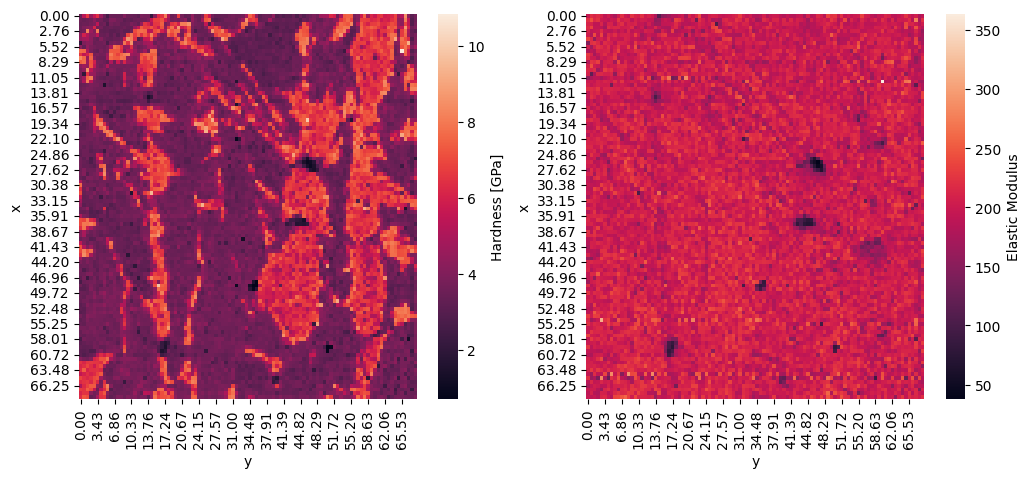

In [6]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))

sns.heatmap(data=df.pivot(index='x', columns='y', values='hardness'),
                cbar_kws={'label': 'Hardness [GPa]'}, ax=axs[0])

x_labels = ['{:.2f}'.format(float(s.get_text())) for s in  axs[0].get_xticklabels()]
y_labels = ['{:.2f}'.format(float(s.get_text())) for s in  axs[0].get_yticklabels()]

axs[0].set_xticklabels(x_labels)
axs[0].set_yticklabels(y_labels)

sns.heatmap(data=df.pivot(index='x', columns='y', values='modulus'),
                cbar_kws={'label': 'Elastic Modulus'}, ax=axs[1])

x_labels = ['{:.2f}'.format(float(s.get_text())) for s in  axs[1].get_xticklabels()]
y_labels = ['{:.2f}'.format(float(s.get_text())) for s in  axs[1].get_yticklabels()]

axs[1].set_xticklabels(x_labels)
axs[1].set_yticklabels(y_labels)

plt.show()


The quantity m2h = Modulus $^2$ / Hardness is an empirical parameter that can be used to highlight the difference between the two phases.
We add this to our data-frame

In [7]:
df['m2h'] = df['modulus']*df['modulus']/df['hardness']
df.head(5)

x          y      load      depth      stiffness     modulus  \
index                                                                   
1      0.0  68.294250  0.999767  88.247395  106268.458800  190.653869   
2      0.0  67.579875  0.999758  95.026045  106864.372258  175.243633   
3      0.0  66.913125  0.999791  82.844008  105616.592448  204.800821   
4      0.0  66.198750  0.999881  59.343424   70601.627419  192.762570   
5      0.0  65.532000  0.999834  74.791846   94219.623185  203.170226   

       hardness           m2h  
index                          
1      3.663756   9921.210337  
2      3.140350   9779.271214  
3      4.181861  10029.835736  
4      8.456658   4393.864240  
5      5.185405   7960.446866

Plotting this quantity as map highlights the two different phases. The artefacts already visible in the plot of the elastic modulus are even more visible in this plot here.

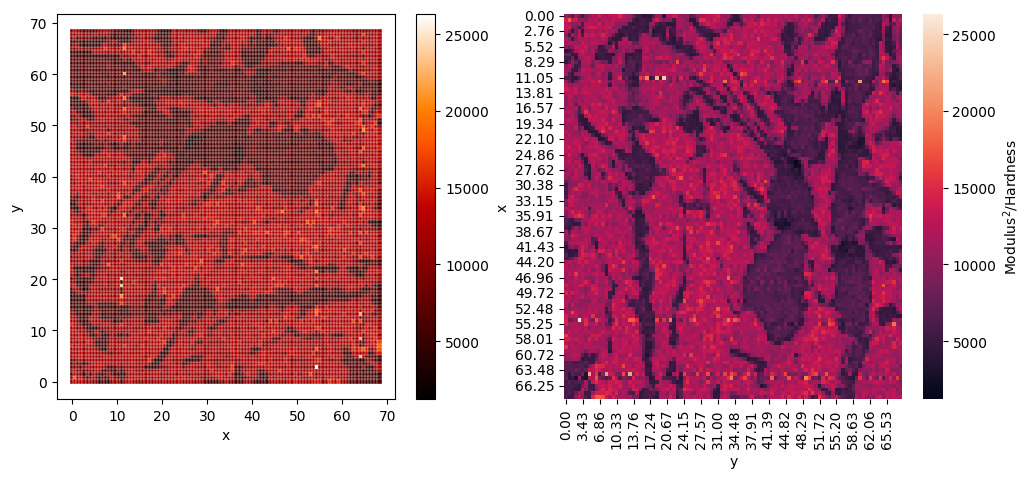

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))

sns.scatterplot(x=df['x'], y=df['y'], hue=df['m2h'],
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type,
                  ax=axs[0])
norm = plt.Normalize(df['m2h'].min(), df['m2h'].max())
sm = plt.cm.ScalarMappable(cmap=colour_scheme, norm=norm)
sm.set_array([])

axs[0].get_legend().remove()
axs[0].figure.colorbar(sm, ax=axs[0])


sns.heatmap(data=df.pivot(index='x', columns='y', values='m2h'),
                cbar_kws={'label': 'Modulus$^2$/Hardness'}, ax=axs[1])

x_labels = ['{:.2f}'.format(float(s.get_text())) for s in  axs[1].get_xticklabels()]
y_labels = ['{:.2f}'.format(float(s.get_text())) for s in  axs[1].get_yticklabels()]

axs[1].set_xticklabels(x_labels)
axs[1].set_yticklabels(y_labels)

plt.show()

# Phase Segmentation

In the following we want to analyse the hardness and elastic modulus separately for the Martensite and ferrite phase. 

## Approach 1: Threshold

The simplest thing we can do is to place a cut at a specific value of the hardness to discriminate between Martensite and ferrite.

_```Exercise:```_ Look at the histogram of the hardness you created above and determine a suitable threshold.

```Solution:```
The distribution looks like two overlapping Gaussian (or: normal) distributions, the minimum between these two is around 5 GPa, so we can use this as a threshold.

In [9]:
df_cut = df[df['hardness']>5]

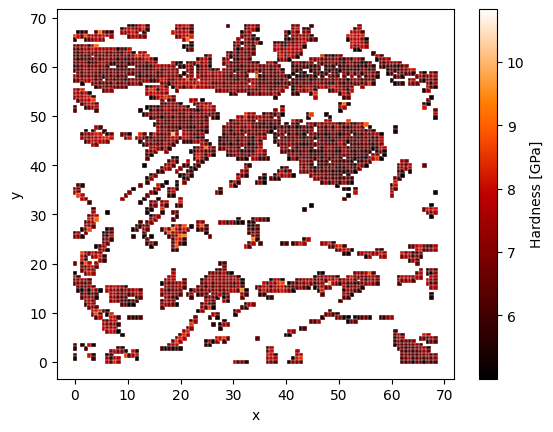

In [10]:
ax = sns.scatterplot(x=df_cut['x'], y=df_cut['y'], hue=df_cut['hardness'],
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type)
norm = plt.Normalize(df_cut['hardness'].min(), df_cut['hardness'].max())
sm = plt.cm.ScalarMappable(cmap=colour_scheme, norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax, label='Hardness [GPa]')
plt.show()

In [12]:
hardness_cut_cluster1_mean = np.mean(df[df['hardness']>5]['hardness'])
hardness_cut_cluster1_std  = np.std(df[df['hardness']>5]['hardness'])

hardness_cut_cluster2_mean = np.mean(df[df['hardness']<=5]['hardness'])
hardness_cut_cluster2_std  = np.std(df[df['hardness']<=5]['hardness'])

print('Manual threshold:')
print('-----------------')
print('Mean hardness cluster 1: {:.2f} \u00B1 {:.2f} GPa'.format(hardness_cut_cluster1_mean, hardness_cut_cluster1_std))
print('Mean hardness cluster 2: {:.2f} \u00B1 {:.2f} GPa'.format(hardness_cut_cluster2_mean, hardness_cut_cluster2_std))

Manual threshold:
-----------------
Mean hardness cluster 1: 6.62 ± 0.84 GPa
Mean hardness cluster 2: 3.64 ± 0.49 GPa


## Approach 2: Clustering on hardness values

The approach above works - however, we needed to determine the threshold at which we say that a given measurement point belongs to one phase rather than the other manually.

_```Exercise```:_
We can improve on this by using a clustering algorithm. In a first step, we use the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering algorithm as a first approach. Here, we only pass the hardness values to the clustering algorithm.



In [ ]:
##
## Your code goes here
##

_```Solution```_

The simplest solution is to use the hardness as input to the clustering algorithm.
We can use the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm for this. We know that we have two phases in the material (Martensite and ferrite), hence, we choose ```n_clusters=2```.

In [13]:
##
## solution
##

# N.B. the clustering algorithm expects a Pandas data-frame. 
#      However, selecting only one column will result in a Pandas series that we then need to convert back into a data-frame


kmeans = KMeans(n_clusters=2)
kmeans.fit(pd.DataFrame(df['hardness']))
df['y_hat_kmeans'] = kmeans.predict(pd.DataFrame(df['hardness']))

As a first step, we plot the two clusters we have identified this way.
It shows that the clustering algorithm has, essentially, made the same choice as we did.

In [ ]:
##
## your code goes here
##

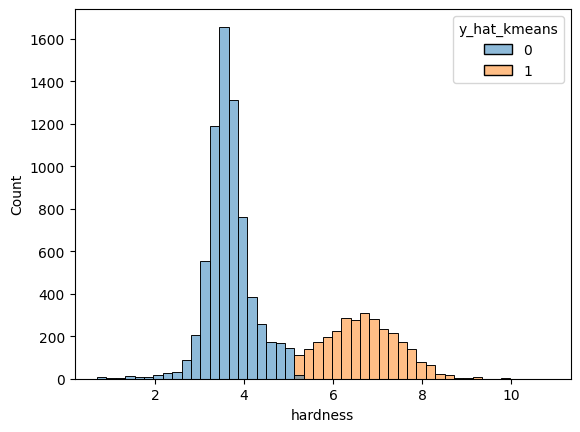

In [14]:
##
## solution
## 
sns.histplot(data=df, x='hardness', hue='y_hat_kmeans')


plt.show()

The resulting figure showing the Martensite and ferrite phases is, therefore, very similar to what we have done before.

In [ ]:
## scatter-plot to show the two phases
##
## your code goes here
##

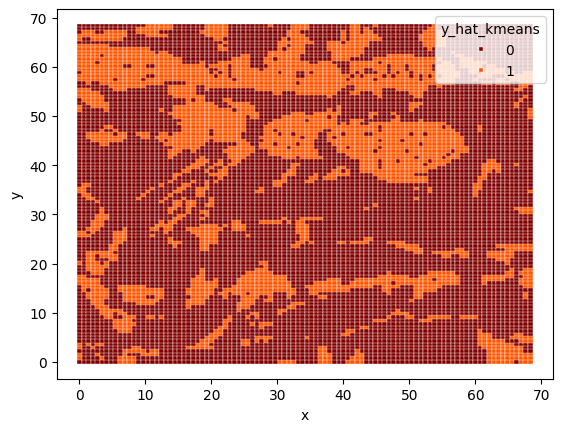

In [15]:
##
## solution
##
ax = sns.scatterplot(x=df['x'], y=df['y'], hue=df['y_hat_kmeans'],
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type)

plt.show()

_```Exercise:```_ Reflect on why that worked. Discuss with your neighbours.

_```Solution:```_:

The KMeans clustering algorithms has a number of assumptions:
- We know the number of clusters beforehand
- The number of elements in each cluster is roughly the same
- The distribution of each variable is roughly spherical.

All three of these assumptions are ---more or less-- fulfilled in our case.
The area of the Martensite and ferrite phase is not too different, we know that we only have two phases (Martensite and ferrite) and the distribution of the hardness for each phase roughly follows a Gaussian (or: normal) distribution.

This worked fairly well, however we have already noticed that there are a number of "islands" with low hardness values in the first heatmap of the hardness we looked at that are not identified in this approach.

_```Exercise:```_ Try to identify the artefacts with low hardness values and remove them for the subsequent analysis



In [ ]:
##
## your code goes here
##

In [ ]:
## scatter-plot to show the two phases
##
## your code goes here
##

_```Solution:```_ 

Following our approach above try to increase the numbers of clusters: Martensite, ferrite, artefacts and use the KMeans algorithm with ```n_clusters=3```.

In [18]:
##
## solution
##
kmeans_3clusters = KMeans(n_clusters=3)
kmeans_3clusters.fit(pd.DataFrame(df['hardness']))
y_hat_kmeans_3clusters =  kmeans_3clusters.predict(pd.DataFrame(df['hardness']))

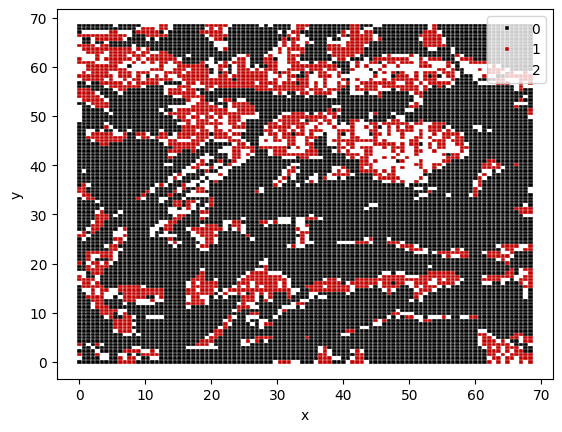

In [19]:
ax = sns.scatterplot(x=df['x'], y=df['y'], hue=y_hat_kmeans_3clusters,
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type)

plt.show()

_```Solution:```_

If you have used this approach you will find that this has not worked.
Discuss why this is the case.

We have now violated at least one of the assumptions: The small black areas are much smaller than the other areas. Also, their hardness is lower than the ferrite phase, but there is no distinct peak that the clustering algorithm can use.

We, therefore, need a different approach if we want to improve the analysis further.
The next simplest approach is to use a threshold again - based on the heatmap, we can try a value of ```hardness < 2```.

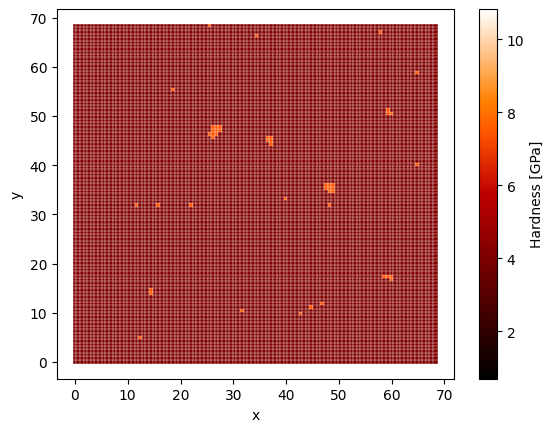

In [20]:
ax = sns.scatterplot(x=df['x'], y=df['y'], hue=df['hardness']<2,
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type)
norm = plt.Normalize(df['hardness'].min(), df['hardness'].max())
sm = plt.cm.ScalarMappable(cmap=colour_scheme, norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax, label='Hardness [GPa]')
plt.show()

We can put this into a new dataframe with only the Martensite phase in it:

In [21]:
df_martensite = df[(df['y_hat_kmeans']== 1) & (df['hardness']>2) ]


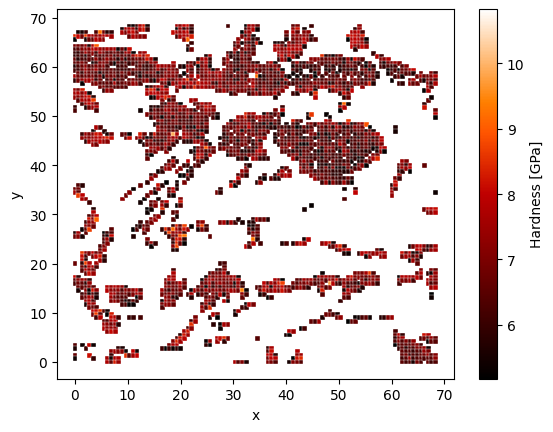

In [22]:
ax = sns.scatterplot(x=df_martensite['x'], y=df_martensite['y'], hue=df_martensite['hardness'],
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type)
norm = plt.Normalize(df_martensite['hardness'].min(), df_martensite['hardness'].max())
sm = plt.cm.ScalarMappable(cmap=colour_scheme, norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax, label='Hardness [GPa]')
plt.show()

## Identify individual Martensite islands

In the next step, we want to identify the individual martensite islands

_```Exercise:```_

Discuss with your neighbour how you can approach this.

_```Solution:```:_

Most clustering algorithms, including the KMean algorithm we have used so far, require that we know the number of clusters beforehand. However, this is highly specific to the individual part of the sample that we want to analyse. Instead of counting the number of potential clusters, we need to choose a method that does not require us to determine the number of clusters as a free hyperparameter.

One approach is Density-Based Spatial Clustering of Applications with Noise [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

The main parameters that we need to adjust are:

- ```eps```: maximum distance between two samples for consideration of the mutual neighbourhood
- ```min_samples```: number of samples for the determination of core points.

In [ ]:
##
## Your code goes here
## 

In [23]:
##
## Solution
##
# we only fit the x,y position from the filtered dataframe:
df_small = df_martensite[['x','y']].copy()


# now configure the DBSCAN algorithm
db = DBSCAN(eps=2)
db.fit(df_small)

labels_martensite = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_martensite)) - (1 if -1 in labels_martensite else 0)
print(n_clusters_)

# add labels to original dataframe
df_small['label_martensite'] = labels_martensite

25


In [24]:

# merge information into the dataframe containing all information about the Martensite phase
df_martensite = df_martensite.join(df_small.drop(columns=['x','y']), on='index')
df_martensite

x          y      load      depth     stiffness     modulus  \
index                                                                        
4       0.000000  66.198750  0.999881  59.343424  70601.627419  192.762570   
5       0.000000  65.532000  0.999834  74.791846  94219.623185  203.170226   
7       0.000000  64.150875  0.999774  65.323818  81221.954848  201.846066   
8       0.000000  63.436500  0.999868  68.826484  83269.585925  194.664997   
9       0.000000  62.769750  0.999848  69.795739  81723.509967  187.071901   
...          ...        ...       ...        ...           ...         ...   
9993   68.341875   4.810125  0.999761  66.881090  76260.524117  181.825553   
9994   68.341875   4.095750  0.999856  67.443512  82880.137924  198.597836   
9998   68.341875   1.333500  0.999726  64.617700  78299.516050  195.871620   
9999   68.341875   0.666750  0.999895  63.794910  75781.014903  191.462404   
10000  68.341875   0.000000  0.999805  67.964040  82705.830419  196.187045   

       hardness          m2h  y_hat_kmeans  label_martensite  
index                                                         
4      8.456658  4393.864240             1                 0  
5      5.185405  7960.446866             1                 0  
7      6.901659  5903.194620             1                 0  
8      6.180447  6131.346131             1                 0  
9      6.000315  5832.342686             1                 0  
...         ...          ...           ...               ...  
9993   6.566047  5035.073701             1                22  
9994   6.451397  6113.575130             1                22  
9998   7.061848  5432.811742             1                22  
9999   7.257154  5051.271389             1                22  
10000  6.347033  6064.149364             1                22  

[2962 rows x 10 columns]

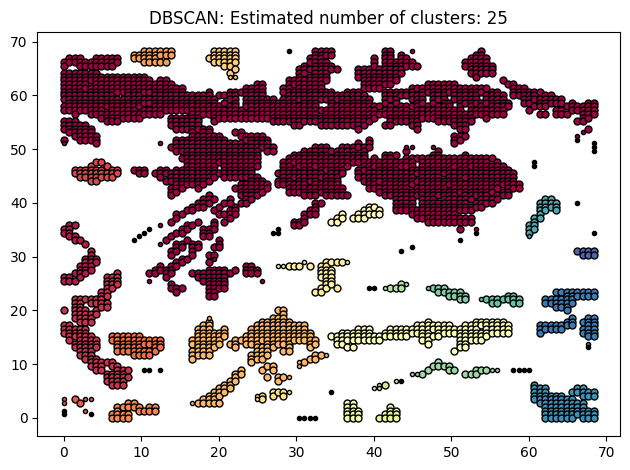

In [25]:
##
## Plot the clusters that we have found
##

plot_dbscan(db, df_martensite.to_numpy())

# Hardness analysis

We now want to analyse the hardness of the Martensite and ferrite phase.
In a first step, we use the approaches to separate the Martensite and ferrite phase as a whole, in the next step, we then want to compare the hardness of the individual Martensite structures.

_```Exercise```:_

Compare the mean hardness (including standard deviation) of the Martensite and ferrite phase for the approach using the threshold and the clustering approach using the hardness itself.

In [ ]:
##
## Your code here
##

_```Solution:```_


In [43]:
hardness_cut_martensite_mean = np.mean(df[df['hardness']>5]['hardness'])
hardness_cut_martensite_std  = np.std(df[df['hardness']>5]['hardness'])

hardness_cut_ferrite_mean = np.mean(df[df['hardness']<=5]['hardness'])
hardness_cut_ferrite_std  = np.std(df[df['hardness']<=5]['hardness'])

print('Manual threshold:')
print('-----------------')
print('Mean hardness Martensite: {:.2f} \u00B1 {:.2f} GPa'.format(hardness_cut_martensite_mean, hardness_cut_martensite_std))
print('Mean hardness Ferrite: {:.2f} \u00B1 {:.2f} GPa'.format(hardness_cut_ferrite_mean, hardness_cut_ferrite_std))

Manual threshold:
-----------------
Mean hardness Martensite: 6.62 ± 0.84 GPa
Mean hardness Ferrite: 3.64 ± 0.49 GPa


In [48]:
hardness_kmeans_martensite_mean = np.mean(df[df['y_hat_kmeans']==1]['hardness'])
hardness_kmeans_martensite_std  = np.std(df[df['y_hat_kmeans']==1]['hardness'])

hardness_kmeans_ferrite_mean = np.mean(df[df['y_hat_kmeans']==0]['hardness'])
hardness_kmeans_ferrite_std  = np.std(df[df['y_hat_kmeans']==0]['hardness'])


print('KMeans:')
print('-----------------')
print('Mean hardness Martensite: {:.2f} \u00B1 {:.2f} GPa'.format(hardness_kmeans_martensite_mean,hardness_kmeans_martensite_std))
print('Mean hardness Ferrite: {:.2f} \u00B1 {:.2f} GPa'.format(hardness_kmeans_ferrite_mean,hardness_kmeans_ferrite_std))

KMeans:
-----------------
Mean hardness Martensite: 6.68 ± 0.80 GPa
Mean hardness Ferrite: 3.67 ± 0.52 GPa


_```Exercise:```_

Now compute the hardness of the individual Martensite islands.
In a first step, visualise the hardness (and the corrsponding standard deviation) against the cluster number, i.e. the $x$ axis should show the cluster ID, the $y$ axis the hardness for each cluster and the associated standard deviation.

In [ ]:
##
## Your code here
##

_```Solution:```_

In [26]:
##
## Solution
## 
data = []
for i in set(labels_martensite):
    if i>-1:
        mean = np.mean(df_martensite[df_martensite['label_martensite']==i]['hardness'])
        std  = np.std(df_martensite[df_martensite['label_martensite']==i]['hardness'])
        data.append([i,mean, std])
        #print('Martensite cluster: ', i)
        #print('Mean hardness {:.2f} \u00B1 {:.2f} GPa'.format(mean, std))
        #print('-----------------')

df_martensite_hardness = pd.DataFrame(data, columns=['cluster','mean', 'std'])
df_martensite_hardness

cluster      mean       std
0         0  6.607844  0.762432
1         1  7.023141  0.897020
2         2  6.938111  0.846814
3         3  7.208710  0.800752
4         4  6.430116  1.112942
5         5  6.778862  0.741465
6         6  7.012108  0.973908
7         7  7.018938  0.908857
8         8  6.770563  0.787274
9         9  7.109181  0.970165
10       10  6.829360  1.104844
11       11  6.465875  0.886983
12       12  6.480615  0.890290
13       13  6.902650  0.781889
14       14  7.119986  0.792770
15       15  7.029269  1.014184
16       16  6.277683  1.156832
17       17  6.988857  1.057536
18       18  6.250240  0.660878
19       19  6.955906  1.037140
20       20  7.036079  0.804318
21       21  6.878617  0.793131
22       22  6.560565  0.547055
23       23  6.910884  0.791509
24       24  7.534749  0.498088

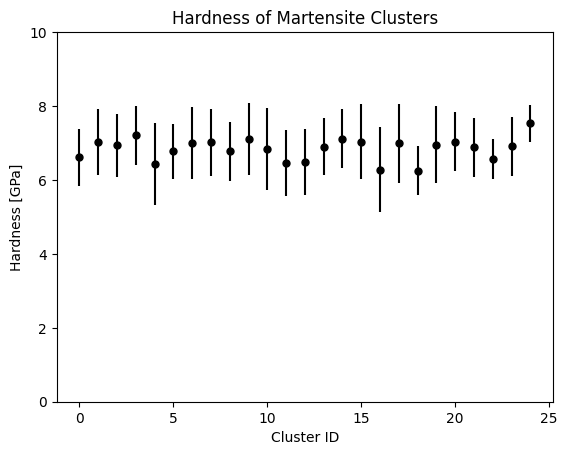

In [42]:
df_martensite_hardness.plot(
    x='cluster',
    y='mean',
    yerr = 'std',
    linestyle='none',
    capsize=0,
    color='black',
    legend=None,
    marker='o',
    markersize=5
)
plt.xlabel('Cluster ID') 
plt.ylabel('Hardness [GPa]') 
plt.ylim(0,10)
plt.title('Hardness of Martensite Clusters')
plt.show()

_```Exercise:```_

Now combine the measurements of the hardness of the individual Martensite clusters into one number.
Remember that each cluster has an associated uncertainty (measured by the standard deviation) that you need to take into account.

Assume that the measurements of each cluster are independent.
Discuss this assumption with your neighbour.

In [ ]:
##
## Your code here
##

_```Solution:```_

The assumption is a bit optimistic. The areas on the sample are not fully independent from each other as they come from the same physical specimen that was cast as a whole We can assume that the forming of the Martensite and ferrite phases are largely stochastic, given a set of mixture of elements and process parameters. However, they are in close proximity in our sample.

However, for this exercise we assume that the regions are apart "far enough" to be able to make this assumption.

In [50]:
##
## Solution
##
combined_mean =  np.sum(df_martensite_hardness['mean']/(df_martensite_hardness['std']**2))/np.sum(1.0/(df_martensite_hardness['std']**2))
inv_var = np.sum(1.0/(df_martensite_hardness['std']**2))
combined_std = np.sqrt(1.0/inv_var)


print('hardness (KMeans): {:.2f} \u00B1 {:.2f} GPa'.format(hardness_kmeans_martensite_mean,hardness_kmeans_martensite_std))
print('hardness (Threshold): {:.2f} \u00B1 {:.2f} GPa'.format(hardness_cut_martensite_mean, hardness_cut_martensite_std))
print('combined hardness from all clusters: {:.2f} \u00B1 {:.2f} GPa'.format(combined_mean, combined_std))

hardness (KMeans): 6.68 ± 0.80 GPa
hardness (Threshold): 6.62 ± 0.84 GPa
combined hardness from all clusters: 6.87 ± 0.16 GPa
